In [2]:
import pandas as pd
import numpy as np
import datetime as dt
import dateutil as du
from glmnet import ElasticNet
%pylab inline
exec(open("/Users/raghuramkowdeed/Documents/afp/models/quintile_model.py").read())
exec(open("/Users/raghuramkowdeed/Documents/afp/get_signal_names.py").read())


Populating the interactive namespace from numpy and matplotlib


In [3]:
data = pd.read_csv('/Users/raghuramkowdeed/Desktop/rps_data_clean.csv')

In [4]:
data = data.set_index(['date'])
data.index = [ dt.datetime.strptime(str(x),'%Y%m%d') for x in data.index ]

In [5]:
look_back = 1*12
sig_names = get_signal_names()
num_buckets = 10
rebalance_dates = np.unique(data.index)

In [6]:
num_sig_vec = range(3,30,3)

In [7]:
def get_lambda(model, num_signals= 5):
    coef_path = model.coef_path_
    
    num_coef = [ (np.where( np.abs(coef_path[:,i]) > 1e-8 )[0]).shape[0] for i in range(coef_path.shape[1]) ]
    num_coef = np.array(num_coef)
    #print(num_coef)
    coef_ind = ( np.abs(num_coef - num_signals )).argmin()
    s = model.lambda_path_[coef_ind]
    return(s)


In [15]:
corr_df = pd.DataFrame()  
for num_sig in num_sig_vec:
    corr_vec = []
    model_vec = []
    this_dates = []
    for ind in range( 200, rebalance_dates.shape[0] ) :
        
        r_d = rebalance_dates[ind]
        this_dates.append(r_d)
        #print(r_d)
        train_end_date = rebalance_dates[ind-1] 
        #train_end_year = train_end_date.year

        train_start_date = rebalance_dates[ind-look_back]
        #train_start_year = train_start_date.year

        #curr_year = r_d.year

        train_data = data
        train_data = train_data[train_data.index>=train_start_date]
        train_data = train_data[train_data.index<=train_end_date]

        test_data = data
        test_data = test_data[test_data.index==r_d]


        #model = QuintileSort(num_buckets,'median')
        #model = KNeighborsRegressor(n_neighbors=int(train_data.shape[0]*1.0/num_buckets)) 
        model = ElasticNet(alpha=0.5 )
        
        train_x = train_data[ sig_names ]
        train_y = train_data['ret']

        
        model.fit(train_x,train_y)

        s = get_lambda(model,num_sig)
        #model.ret_profile.plot(kind='bar')

        test_x = test_data[sig_names]
        test_y = test_data['ret']

        pred_ret = model.predict(test_x, s)
        pred_ret = pd.Series(pred_ret, index = test_x.index)
        corr = pred_ret.corr(test_y, method='kendall')

        corr_vec.append(corr)
        model_vec.append(model)


    corr_vec = pd.Series(corr_vec, index = this_dates)
    corr_df[str(num_sig)] = corr_vec
    print(num_sig)
    print(np.mean(corr_vec))
    print('--------------')

3
0.007898781580773421
--------------
6
0.01505242391293145
--------------
9
0.018780880999818127
--------------
12
0.019164502753518484
--------------
15
0.019565403673391116
--------------
18
0.02011366062795244
--------------
21
0.020066607864863396
--------------
24
0.02016268951054726
--------------
27
0.020540946210330608
--------------


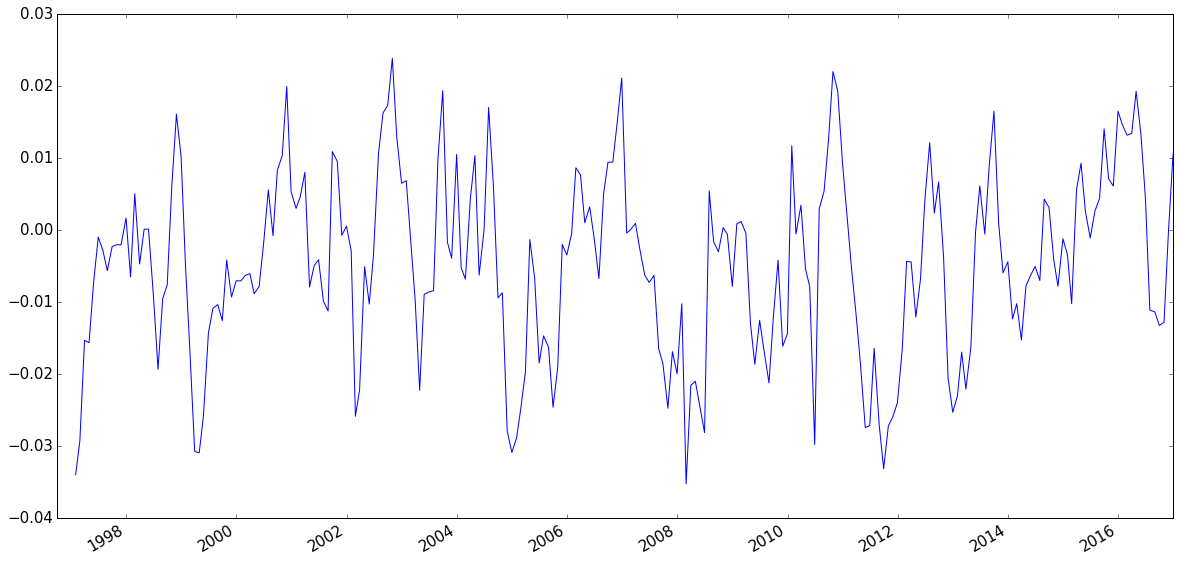

In [17]:
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10
df = corr_df.iloc[:,0:4].mean(axis=1) - corr_df.iloc[:,4:].mean(axis=1)
df.rolling(window=5).mean().plot()

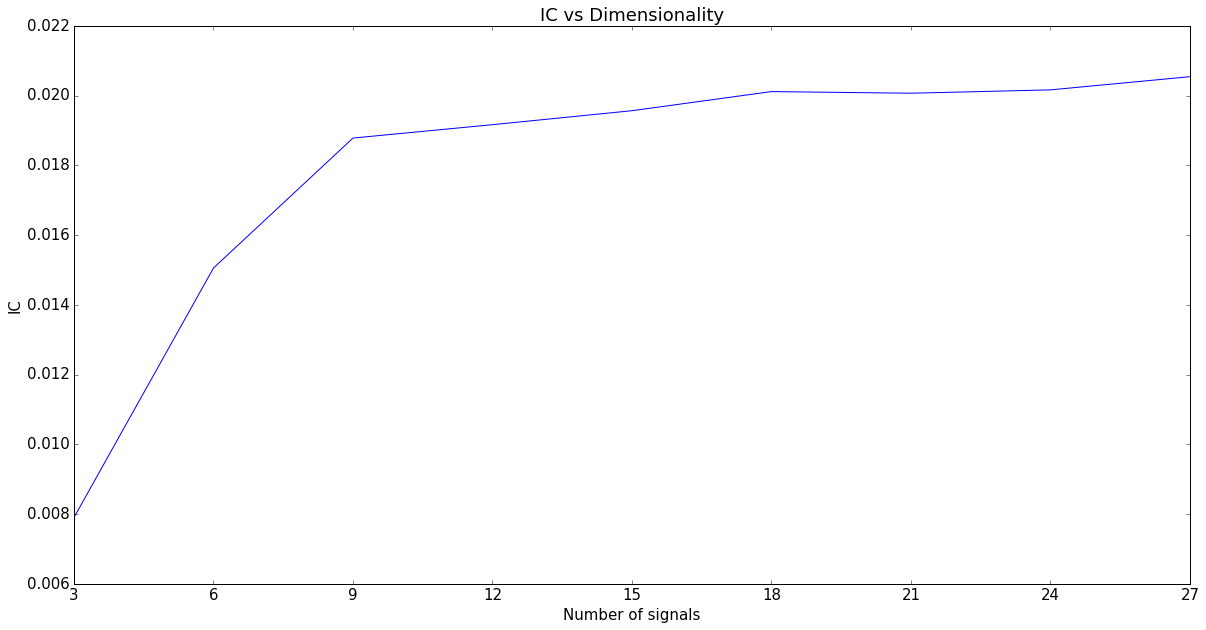

In [19]:
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10
rcParams['font.size']=  15
pylab.title('IC vs Dimensionality')
corr_df.mean(axis=0).plot()
pylab.xlabel('Number of signals')
pylab.ylabel('IC')